In [185]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle


# Preprocessing

In [186]:
def preprocessing(x_data, y_data, split_ratio, scaler, sampler):
    scaler = StandardScaler()
    if(scaler):
        x_data = scaler.fit_transform(x_data)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=split_ratio/100, random_state = 30)

    if(sampler):
        x_train, y_train = RandomOverSampler().fit_resample(x_train, y_train)

    return x_train, x_test, y_train, y_test

# Model Evaluation

In [187]:
def evaluate_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Return metrics
    return accuracy, conf_matrix, report


# Plotting ROC and AUC

In [188]:
def plot_roc_auc_ovr(classifier, x, y, test_size, classifier_name, dataset_name):
    """
    Plot ROC curve and compute AUC for a given classifier using One-vs-Rest (OvR) strategy.
    """
    # Binarize the labels for multiclass classification
    y_bin = label_binarize(y, classes=np.unique(y))
    n_classes = y_bin.shape[1]

    # Split into train and test sets
    x_train, x_test, y_train_bin, y_test_bin = preprocessing(x, y_bin, split_ratio= test_size, scaler = True, sampler = True)

    # Apply One-vs-Rest strategy
    ovr_clf = OneVsRestClassifier(classifier)
    ovr_clf.fit(x_train, y_train_bin)

    # For classifiers with decision_function (e.g., SVM) or predict_proba (e.g., Random Forest, MLP)
    if hasattr(ovr_clf, "decision_function"):
        y_score = ovr_clf.decision_function(x_test)
    else:
        y_score = ovr_clf.predict_proba(x_test)

    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'darkgreen', 'purple', 'yellow', 'pink', 'brown', 'grey', 'cyan', 'lime'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name} on {dataset_name} Dataset')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Code perform preprocessing, model training and testing

In [189]:
import pandas as pd

def perform_operation(x_data, y_data, models, dataset):
    """
    Perform the sub-operations on the given dataset for each classifier and return the best results.
    """

    best_results = []

    for model_name, model in models:

        final_acc = -1
        final_test_size = 0
        final_conf_matrix = None
        final_report = None

        for split_ratio in range(30, 81, 10):  # Loop over split ratios

            # Split the data
            x_train, x_test, y_train, y_test = preprocessing(x_data, y_data, split_ratio, scaler=True, sampler=True)

            # Evaluate the model
            acc, conf_matrix, report = evaluate_model(model, x_train, x_test, y_train, y_test)

            # Keep track of the best result
            if acc > final_acc:
                final_acc = acc
                final_test_size = split_ratio
                final_conf_matrix = conf_matrix
                final_report = report

        # Store the best result for this classifier
        best_results.append({
            "Classifier": model_name,
            "Best Test Size": final_test_size,
            "Best Accuracy": final_acc * 100
        })

        # Generate results and plots
        generate_results(model_name, final_test_size, final_acc * 100, final_conf_matrix, final_report)
        plot_roc_auc_ovr(model, x_data, y_data, final_test_size, model_name, dataset)

    return best_results


In [190]:
def generate_results(model, test_size, accuracy, conf_matrix, report):
    """
    Prints the best result for each classifier and the test split.
    """
    print("\n======================================================================")
    print(f"\nClassifier Model: {model}")
    print(f"\nBest Accuracy for Test Split at {test_size}%")
    print(f"Accuracy: {accuracy}%")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.show()
    print("\n\n")


# Code to use the Classifier

In [191]:
# Load Wine dataset
wine_data = load_wine(as_frame=True)
x_wine = wine_data.data
y_wine = wine_data.target

# Load Handwritten Digit dataset
digits_data = load_digits()
x_digits = digits_data.data
y_digits = digits_data.target


In [192]:
classifiers = {
    'Linear SVM': SVC(kernel='linear'),
    'Polynomial SVM': SVC(kernel='poly', degree=3),
    'Polynomial SVM': SVC(kernel='poly', degree=2),
    'Gaussian SVM': SVC(kernel='rbf'),
    'Sigmoid SVM': SVC(kernel='sigmoid'),
    'Multi-Layer Perceptron': MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators = 20, random_state = 0)
}

WINE DATASET


Classifier Model: Linear SVM

Best Accuracy for Test Split at 30%
Accuracy: 98.14814814814815%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.96      0.98        23
           2       0.93      1.00      0.96        13

    accuracy                           0.98        54
   macro avg       0.98      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54


Confusion Matrix:


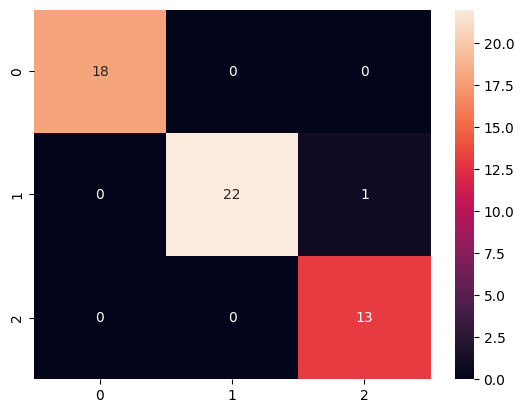

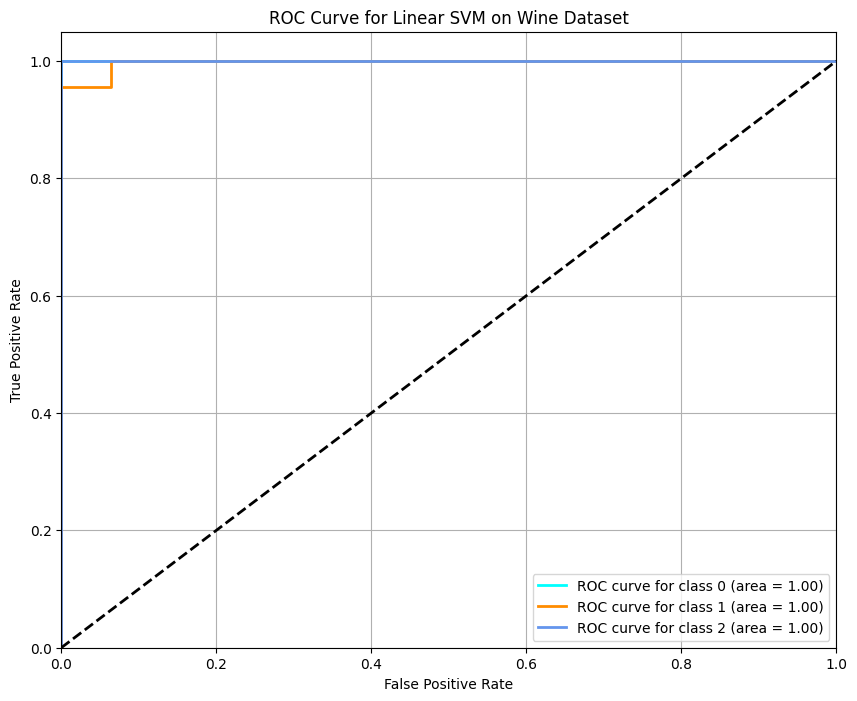



Classifier Model: Polynomial SVM

Best Accuracy for Test Split at 30%
Accuracy: 94.44444444444444%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.96      0.96      0.96        23
           2       0.93      1.00      0.96        13

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.94      0.94      0.94        54


Confusion Matrix:


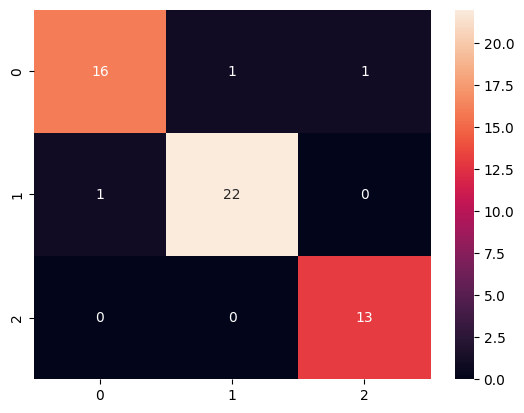

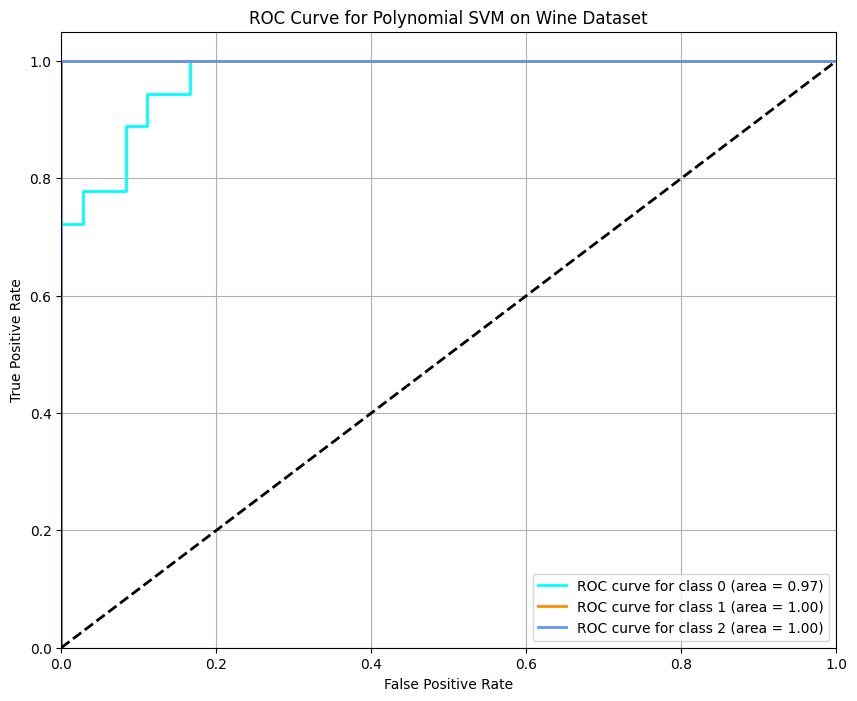



Classifier Model: Gaussian SVM

Best Accuracy for Test Split at 30%
Accuracy: 100.0%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        13

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


Confusion Matrix:


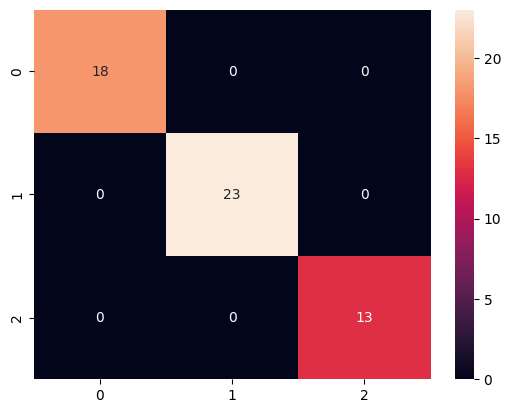

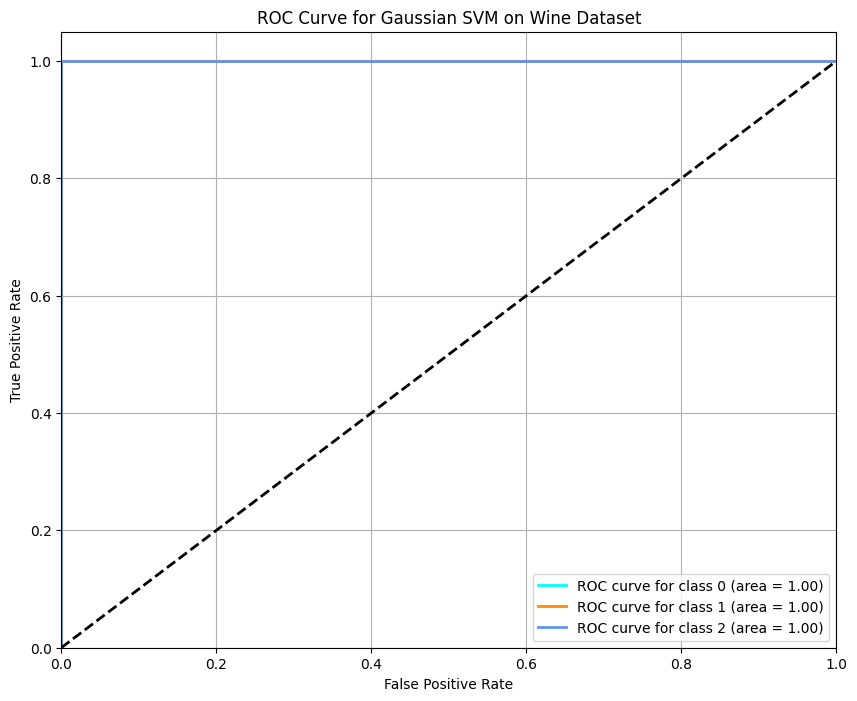



Classifier Model: Sigmoid SVM

Best Accuracy for Test Split at 40%
Accuracy: 98.61111111111111%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.97      0.98        33
           2       0.95      1.00      0.97        18

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


Confusion Matrix:


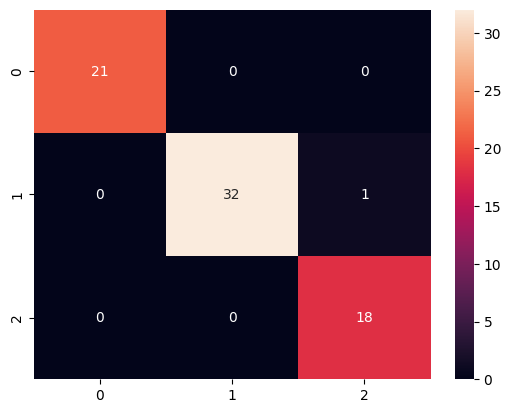

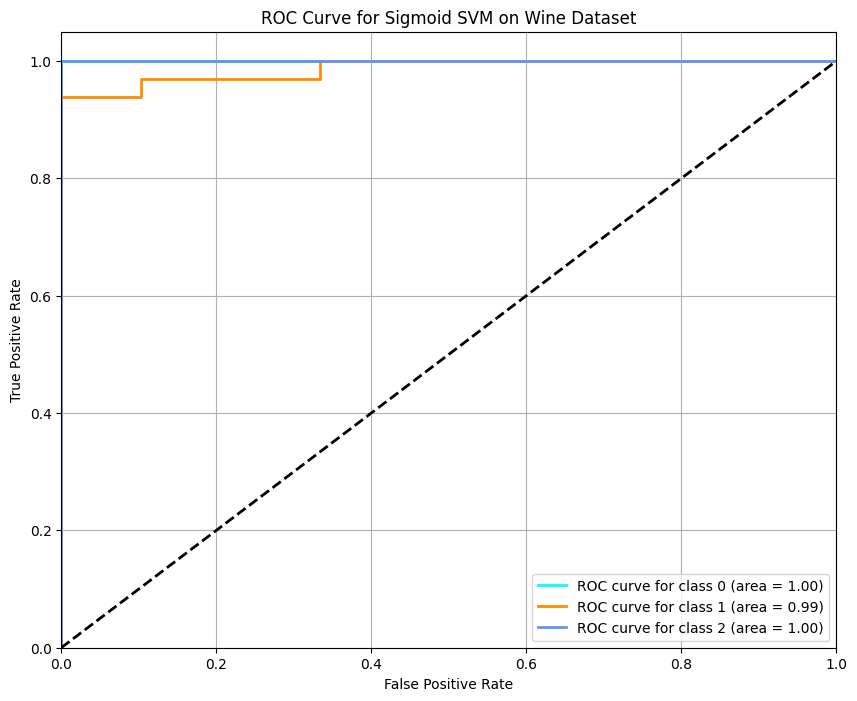



Classifier Model: Multi-Layer Perceptron

Best Accuracy for Test Split at 30%
Accuracy: 96.29629629629629%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.91      0.95        23
           2       0.93      1.00      0.96        13

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54


Confusion Matrix:


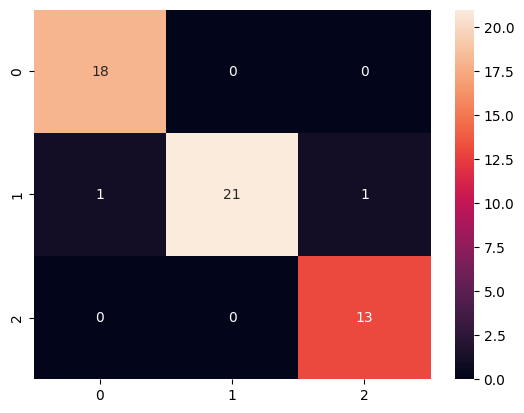

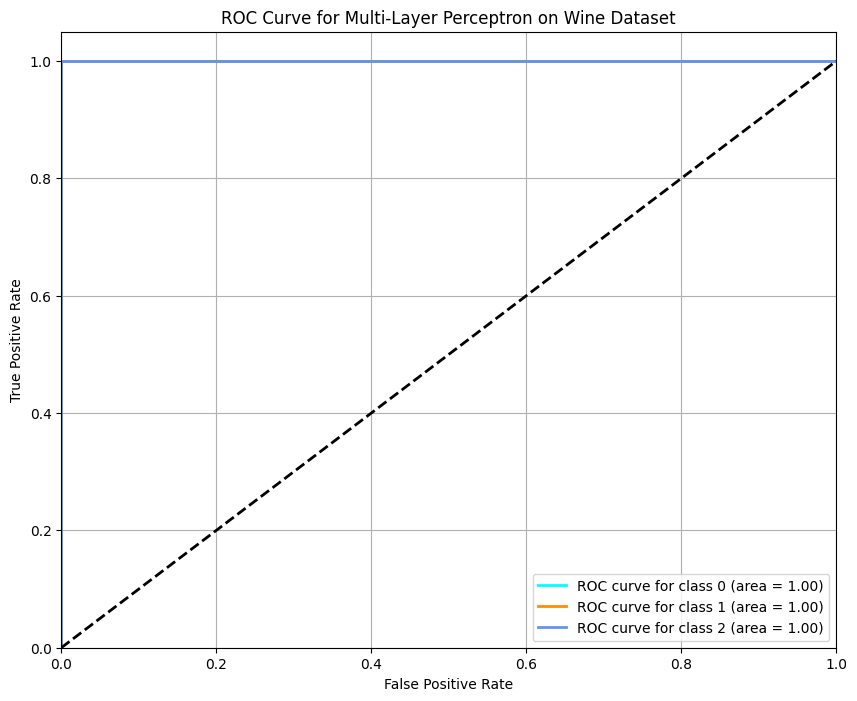



Classifier Model: Random Forest

Best Accuracy for Test Split at 50%
Accuracy: 98.87640449438202%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      0.97      0.99        39
           2       1.00      1.00      1.00        25

    accuracy                           0.99        89
   macro avg       0.99      0.99      0.99        89
weighted avg       0.99      0.99      0.99        89


Confusion Matrix:


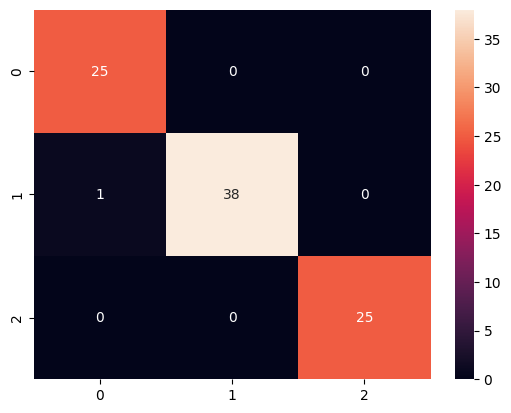

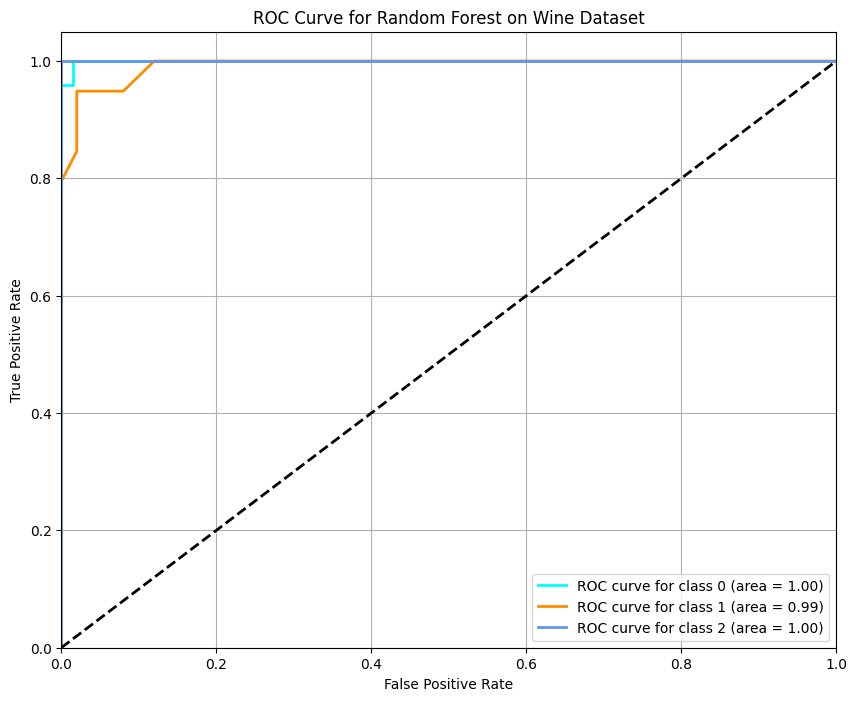


DIGIT DATASET


Classifier Model: Linear SVM

Best Accuracy for Test Split at 50%
Accuracy: 98.33147942157953%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       0.99      0.97      0.98        88
           2       0.99      1.00      1.00       101
           3       0.99      0.95      0.97        81
           4       0.99      0.99      0.99        96
           5       0.97      0.99      0.98        84
           6       1.00      0.99      0.99       100
           7       0.98      0.99      0.98        95
           8       0.95      1.00      0.98        82
           9       0.98      0.95      0.97        88

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899


Confusion Matrix:


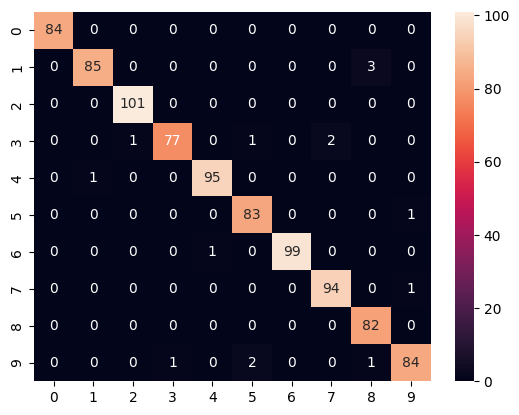

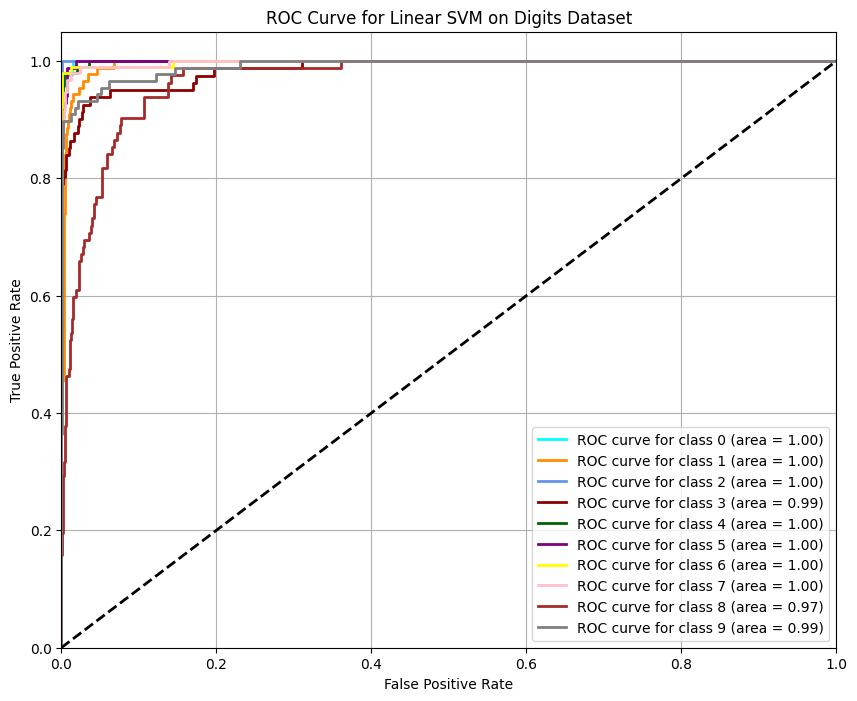



Classifier Model: Polynomial SVM

Best Accuracy for Test Split at 30%
Accuracy: 97.96296296296296%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.97      1.00      0.98        57
           2       0.98      1.00      0.99        61
           3       1.00      0.96      0.98        45
           4       1.00      0.98      0.99        58
           5       0.98      0.96      0.97        55
           6       1.00      0.98      0.99        60
           7       1.00      1.00      1.00        49
           8       0.90      0.96      0.93        49
           9       0.96      0.94      0.95        48

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


Confusion Matrix:


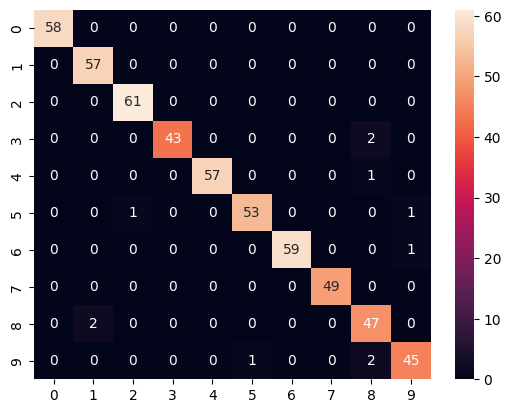

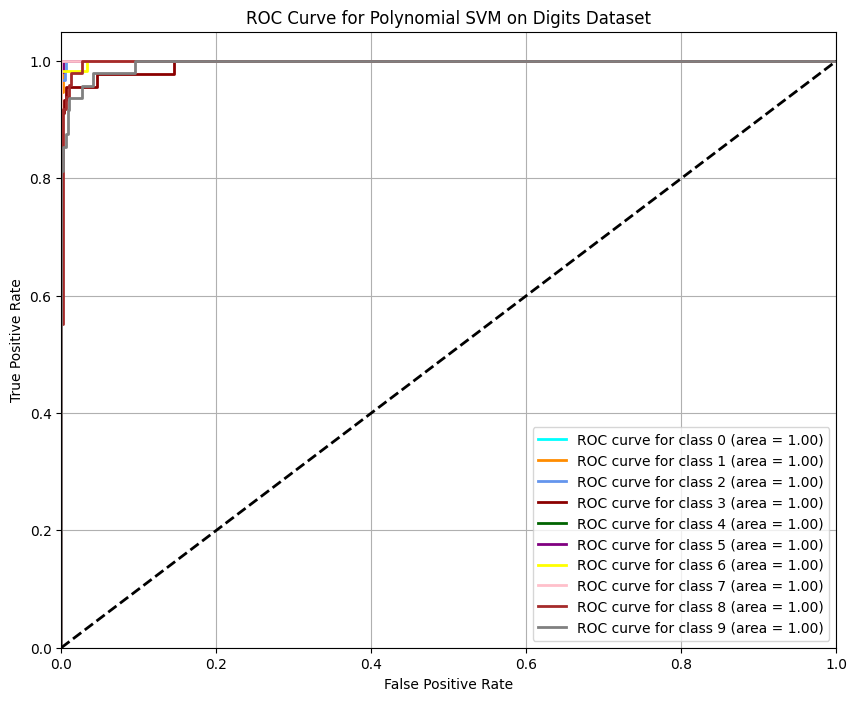



Classifier Model: Gaussian SVM

Best Accuracy for Test Split at 30%
Accuracy: 97.77777777777777%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.98      1.00      0.99        57
           2       1.00      0.98      0.99        61
           3       0.98      0.93      0.95        45
           4       0.96      0.95      0.96        58
           5       0.96      0.98      0.97        55
           6       1.00      1.00      1.00        60
           7       0.98      1.00      0.99        49
           8       0.94      0.98      0.96        49
           9       0.96      0.94      0.95        48

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


Confusion Matrix:


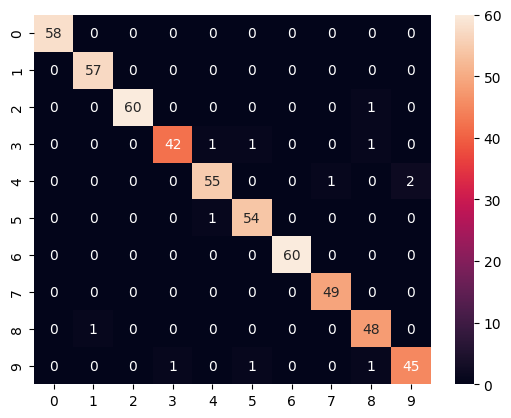

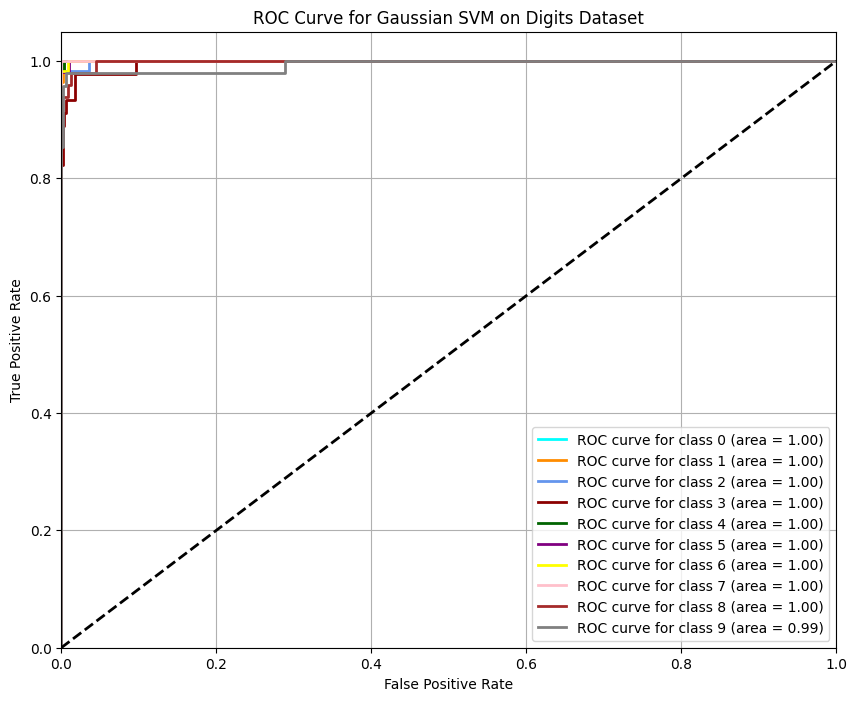



Classifier Model: Sigmoid SVM

Best Accuracy for Test Split at 30%
Accuracy: 95.37037037037037%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.94      0.82      0.88        57
           2       0.92      0.97      0.94        61
           3       0.95      0.91      0.93        45
           4       0.98      0.97      0.97        58
           5       0.98      0.98      0.98        55
           6       1.00      1.00      1.00        60
           7       0.96      1.00      0.98        49
           8       0.90      0.96      0.93        49
           9       0.88      0.94      0.91        48

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540


Confusion Matrix:


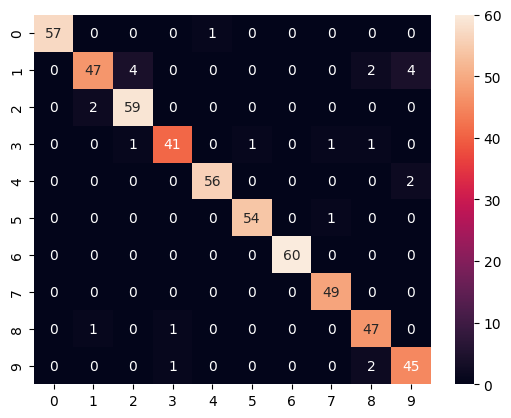

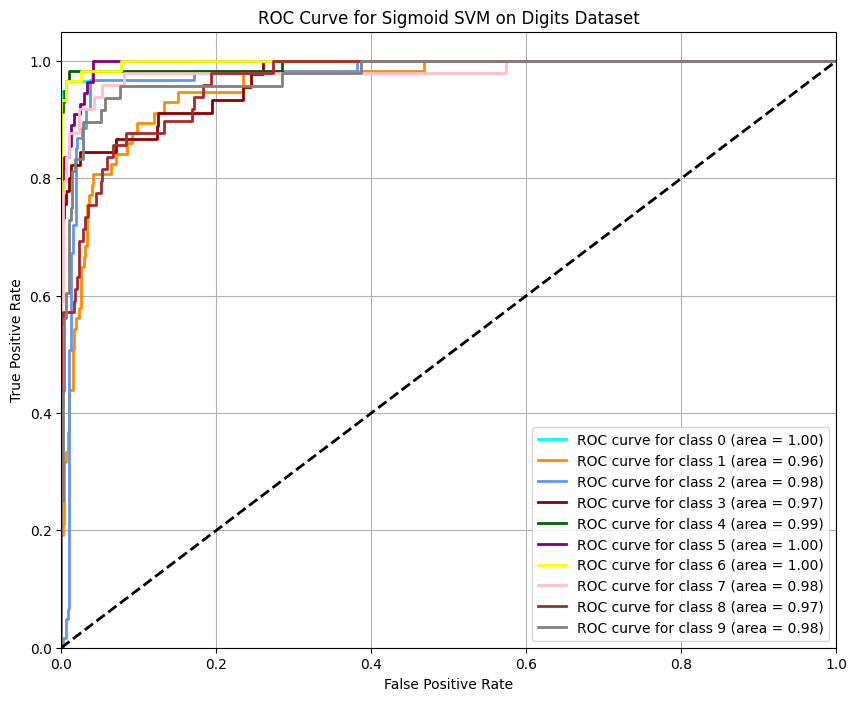



Classifier Model: Multi-Layer Perceptron

Best Accuracy for Test Split at 30%
Accuracy: 95.55555555555556%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.95      0.95      0.95        57
           2       0.97      0.98      0.98        61
           3       0.98      0.89      0.93        45
           4       1.00      0.97      0.98        58
           5       0.96      0.91      0.93        55
           6       0.98      0.98      0.98        60
           7       0.94      0.98      0.96        49
           8       0.87      0.92      0.89        49
           9       0.90      0.96      0.93        48

    accuracy                           0.96       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.96      0.96      0.96       540


Confusion Matrix:


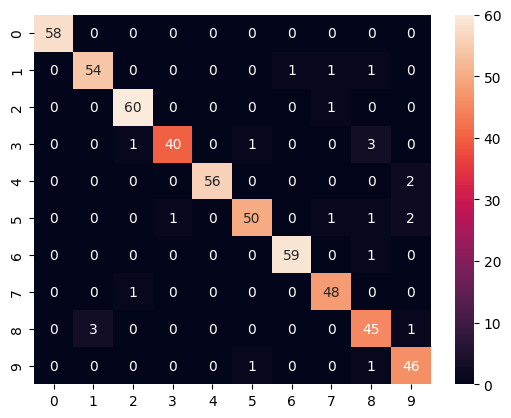

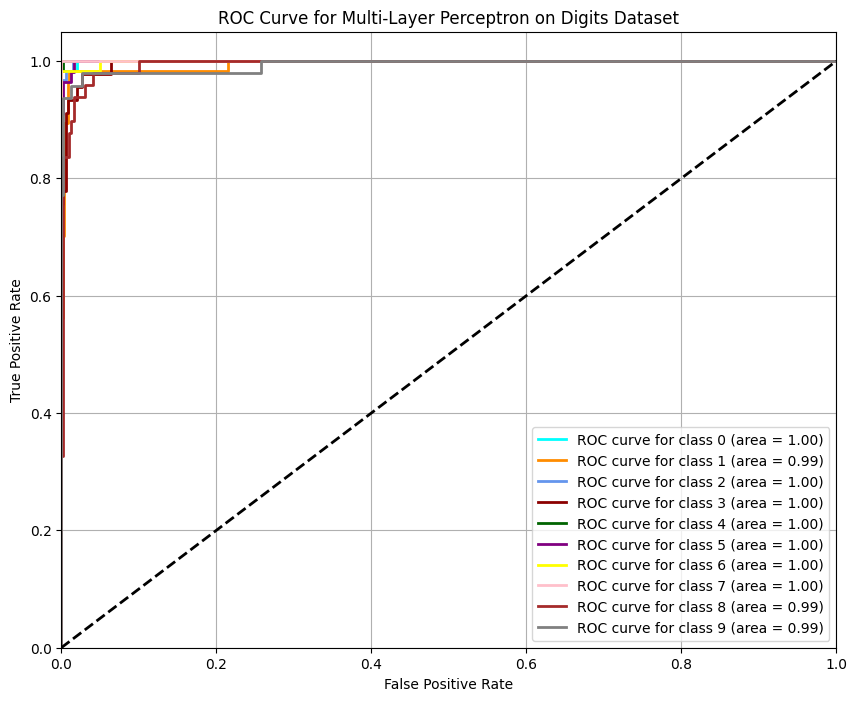



Classifier Model: Random Forest

Best Accuracy for Test Split at 30%
Accuracy: 96.66666666666667%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.92      1.00      0.96        57
           2       1.00      1.00      1.00        61
           3       0.98      0.91      0.94        45
           4       0.95      0.98      0.97        58
           5       0.98      0.95      0.96        55
           6       0.98      0.98      0.98        60
           7       0.98      1.00      0.99        49
           8       0.94      0.90      0.92        49
           9       0.94      0.94      0.94        48

    accuracy                           0.97       540
   macro avg       0.97      0.96      0.96       540
weighted avg       0.97      0.97      0.97       540


Confusion Matrix:


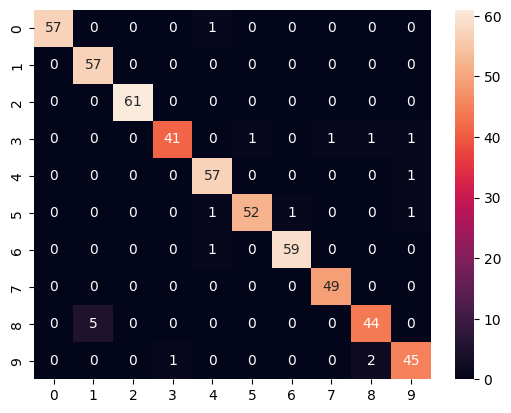

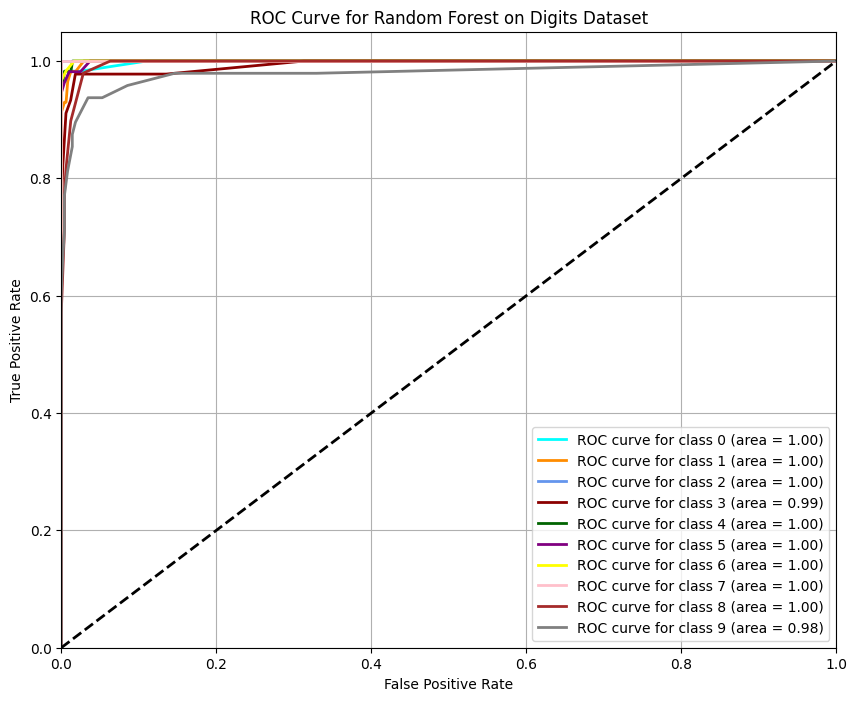

In [193]:
# Measure and listing the best performance of the classifiers and the test split


print("======================================================================")
print("WINE DATASET")
print("======================================================================")
wine_results = perform_operation(x_wine, y_wine, classifiers.items(), dataset = "Wine")


print("\n======================================================================")
print("DIGIT DATASET")
print("======================================================================")
digits_results = perform_operation(x_digits, y_digits, classifiers.items(), dataset = "Digits")

# Code to Use the Classifier after implementing PCA

In [194]:
def perform_pca_operation(x_data, y_data, models, dataset):
    # Apply PCA
    scaler = StandardScaler()
    x_data = scaler.fit_transform(x_data)

    pca = PCA(n_components = 2)
    x_reduced = pca.fit_transform(x_data)

    results = []

    for model_name, model in models:

        final_acc = -1
        final_test_size = 0
        final_conf_matrix = None
        final_report = None

        for split_ratio in range(30, 81, 10):

            # Split the data
            x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = split_ratio/100, random_state = 30)

            # Evaluate model for Wine dataset
            acc, conf_matrix, report = evaluate_model(model, x_train, x_test, y_train, y_test)

            # Keep track of the best result
            if acc > final_acc:
                final_acc = acc
                final_test_size = split_ratio
                final_conf_matrix = conf_matrix
                final_report = report

        results.append({
            "Classifier" : model_name,
            "Best Test Size" : final_test_size,
            "Best Accuracy" : final_acc*100
        })

        generate_results(model_name, final_test_size, final_acc*100, final_conf_matrix, final_report)

    return results


WINE DATASET


Classifier Model: Linear SVM

Best Accuracy for Test Split at 30%
Accuracy: 98.14814814814815%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.96      0.98        23
           2       0.93      1.00      0.96        13

    accuracy                           0.98        54
   macro avg       0.98      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54


Confusion Matrix:


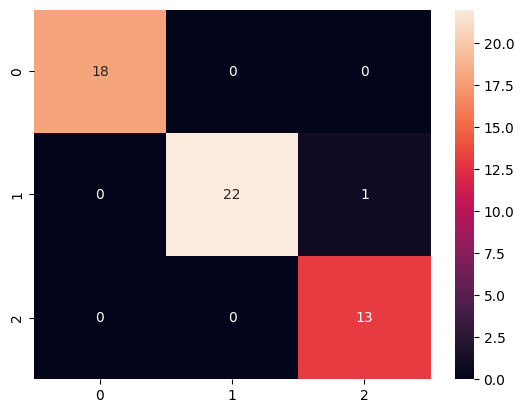






Classifier Model: Polynomial SVM

Best Accuracy for Test Split at 30%
Accuracy: 96.29629629629629%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.96      1.00      0.98        23
           2       0.93      1.00      0.96        13

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54


Confusion Matrix:


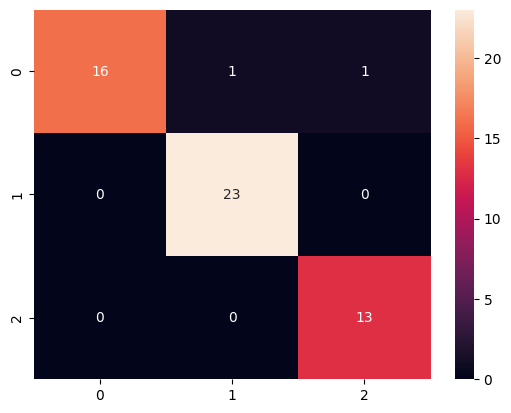






Classifier Model: Gaussian SVM

Best Accuracy for Test Split at 30%
Accuracy: 100.0%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        13

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


Confusion Matrix:


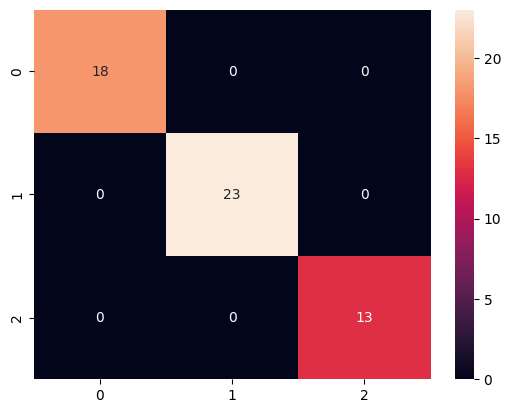






Classifier Model: Sigmoid SVM

Best Accuracy for Test Split at 40%
Accuracy: 98.61111111111111%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.97      0.98        33
           2       0.95      1.00      0.97        18

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


Confusion Matrix:


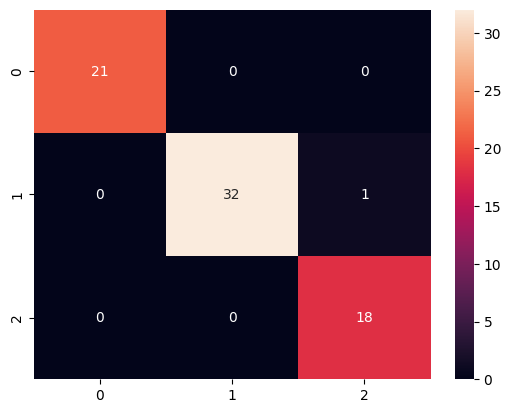






Classifier Model: Multi-Layer Perceptron

Best Accuracy for Test Split at 40%
Accuracy: 97.22222222222221%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.94      0.97        33
           2       0.90      1.00      0.95        18

    accuracy                           0.97        72
   macro avg       0.97      0.98      0.97        72
weighted avg       0.98      0.97      0.97        72


Confusion Matrix:


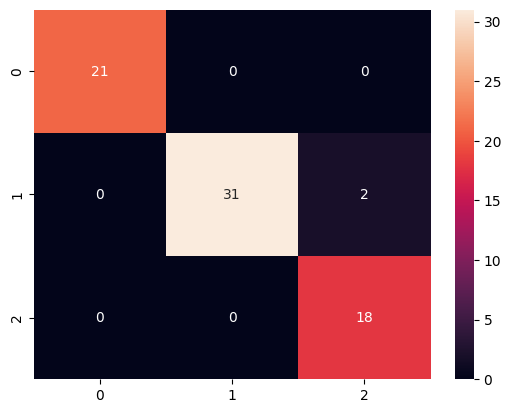






Classifier Model: Random Forest

Best Accuracy for Test Split at 30%
Accuracy: 98.14814814814815%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.96      0.98        23
           2       1.00      1.00      1.00        13

    accuracy                           0.98        54
   macro avg       0.98      0.99      0.98        54
weighted avg       0.98      0.98      0.98        54


Confusion Matrix:


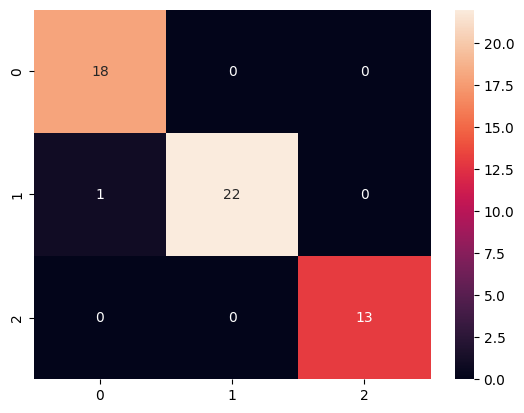





DIGIT DATASET


Classifier Model: Linear SVM

Best Accuracy for Test Split at 50%
Accuracy: 98.33147942157953%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       0.99      0.97      0.98        88
           2       0.99      1.00      1.00       101
           3       0.99      0.95      0.97        81
           4       0.99      0.99      0.99        96
           5       0.97      0.99      0.98        84
           6       1.00      0.99      0.99       100
           7       0.98      0.99      0.98        95
           8       0.95      1.00      0.98        82
           9       0.98      0.95      0.97        88

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899


Confusion Matrix:


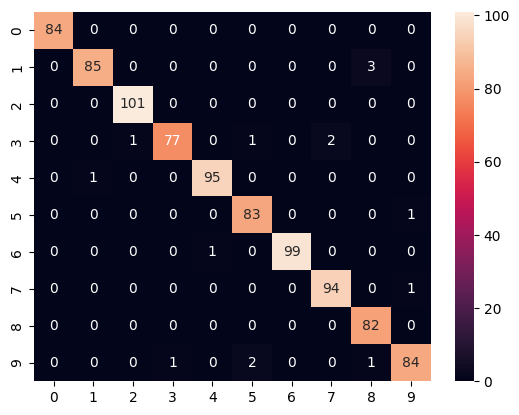






Classifier Model: Polynomial SVM

Best Accuracy for Test Split at 30%
Accuracy: 97.77777777777777%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.97      1.00      0.98        57
           2       0.98      1.00      0.99        61
           3       0.98      0.96      0.97        45
           4       1.00      0.98      0.99        58
           5       0.98      0.96      0.97        55
           6       1.00      0.98      0.99        60
           7       1.00      1.00      1.00        49
           8       0.90      0.96      0.93        49
           9       0.96      0.92      0.94        48

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


Confusion Matrix:


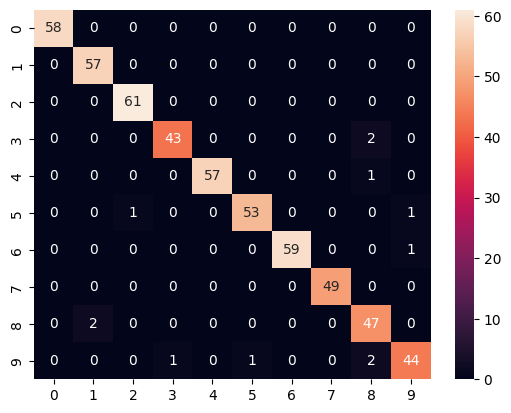






Classifier Model: Gaussian SVM

Best Accuracy for Test Split at 30%
Accuracy: 97.77777777777777%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.98      1.00      0.99        57
           2       1.00      0.98      0.99        61
           3       0.98      0.93      0.95        45
           4       0.95      0.95      0.95        58
           5       0.96      0.98      0.97        55
           6       1.00      1.00      1.00        60
           7       0.98      1.00      0.99        49
           8       0.96      0.98      0.97        49
           9       0.96      0.94      0.95        48

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


Confusion Matrix:


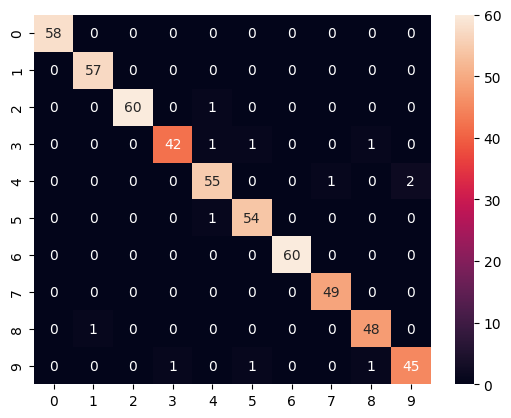






Classifier Model: Sigmoid SVM

Best Accuracy for Test Split at 60%
Accuracy: 95.64411492122335%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       109
           1       0.87      0.95      0.91       105
           2       0.95      0.96      0.96       107
           3       0.99      0.93      0.96       101
           4       0.96      0.96      0.96       119
           5       0.98      0.99      0.99       101
           6       1.00      0.98      0.99       114
           7       0.95      0.99      0.97       110
           8       0.92      0.96      0.94       101
           9       0.96      0.85      0.90       112

    accuracy                           0.96      1079
   macro avg       0.96      0.96      0.96      1079
weighted avg       0.96      0.96      0.96      1079


Confusion Matrix:


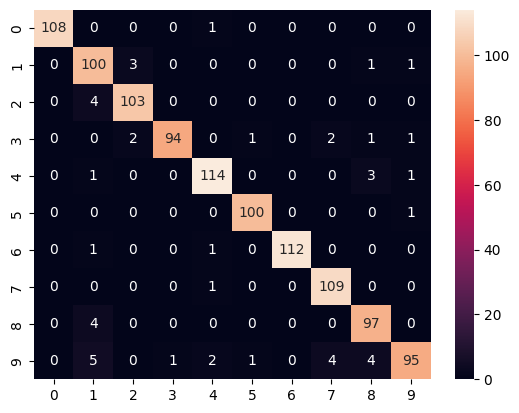






Classifier Model: Multi-Layer Perceptron

Best Accuracy for Test Split at 30%
Accuracy: 95.37037037037037%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       0.96      0.95      0.96        57
           2       0.95      0.98      0.97        61
           3       1.00      0.84      0.92        45
           4       1.00      0.97      0.98        58
           5       0.93      0.93      0.93        55
           6       0.98      0.97      0.97        60
           7       0.92      1.00      0.96        49
           8       0.89      0.98      0.93        49
           9       0.90      0.90      0.90        48

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.96      0.95      0.95       540


Confusion Matrix:


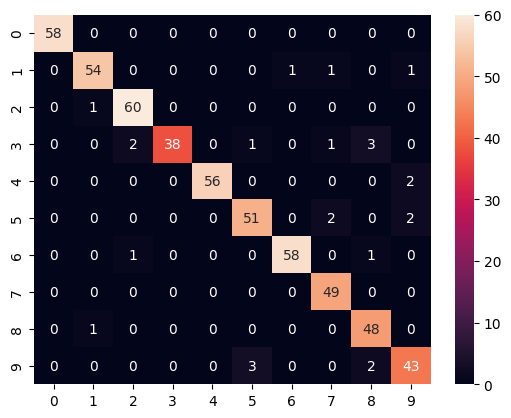






Classifier Model: Random Forest

Best Accuracy for Test Split at 30%
Accuracy: 96.29629629629629%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.92      0.96      0.94        57
           2       1.00      1.00      1.00        61
           3       0.95      0.93      0.94        45
           4       0.97      0.97      0.97        58
           5       1.00      0.95      0.97        55
           6       1.00      1.00      1.00        60
           7       0.98      0.98      0.98        49
           8       0.88      0.92      0.90        49
           9       0.92      0.92      0.92        48

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540


Confusion Matrix:


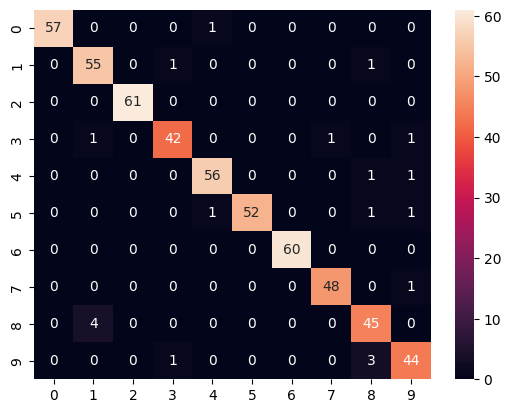

In [195]:
# Measure and listing the best performance of the classifiers and the test split after applying PCA


print("======================================================================")
print("WINE DATASET")
print("======================================================================")
wine_pca_results = perform_pca_operation(x_wine, y_wine, classifiers.items(), dataset = "Wine")


print("\n======================================================================")
print("DIGIT DATASET")
print("======================================================================")
digits_pca_results = perform_pca_operation(x_digits, y_digits, classifiers.items(), dataset = "Digits")

# Conclusion:

In [196]:

def compare_results(before_pca_results, after_pca_results):
    """
    Compare the best accuracy and test size before and after PCA is applied.
    """
    comparison_data = []

    for before, after in zip(before_pca_results, after_pca_results):
        comparison_data.append({
            "Classifier": before["Classifier"],
            "Best Test Size(%) (Before PCA)": before["Best Test Size"],
            "Best Accuracy (%) (Before PCA)": before["Best Accuracy"],
            "Best Test Size(%) (After PCA)": after["Best Test Size"],
            "Best Accuracy (%) (After PCA)": after["Best Accuracy"]
        })

    # Convert to DataFrame for better readability
    comparison_df = pd.DataFrame.from_dict(comparison_data)

    return comparison_df


## Wine Dataset

In [197]:
wine_comparison_df = compare_results(wine_results, wine_pca_results)
wine_comparison_df

,Classifier,Best Test Size(%) (Before PCA),Best Accuracy (%) (Before PCA),Best Test Size(%) (After PCA),Best Accuracy (%) (After PCA)
0,Linear SVM,30,98.148148,30,98.148148
1,Polynomial SVM,30,94.444444,30,96.296296
2,Gaussian SVM,30,100.000000,30,100.000000
3,Sigmoid SVM,40,98.611111,40,98.611111
4,Multi-Layer Perceptron,30,96.296296,40,97.222222
5,Random Forest,50,98.876404,30,98.148148




After applying PCA for  
- Multi-Layer Perceptron : The best test size increased from 30% to 40%. Also the accuracy increased to 97.22%

- Random Forest : The best test size decreased to 30% from 60%. Also the accuracy reduces to 98.14%

## Digits Dataset

In [198]:
digits_comparison_df = compare_results(digits_results, digits_pca_results)
digits_comparison_df

,Classifier,Best Test Size(%) (Before PCA),Best Accuracy (%) (Before PCA),Best Test Size(%) (After PCA),Best Accuracy (%) (After PCA)
0,Linear SVM,50,98.331479,50,98.331479
1,Polynomial SVM,30,97.962963,30,97.777778
2,Gaussian SVM,30,97.777778,30,97.777778
3,Sigmoid SVM,30,95.370370,60,95.644115
4,Multi-Layer Perceptron,30,95.555556,30,95.370370
5,Random Forest,30,96.666667,30,96.296296


After applying PCA for
- Polynomial SVM : The best test split % went from 40% to 30%. The best accuracy also fell to 97.77%

- Sigmoid SVM : The test split ratio remains same and the change in accuracy rather small( 0.185%).

- Multi-Layer Perceptron : The test split ratio changes from 40% to 30% and the accuracy increases to 95.37%.

- Random Forest : The test changes from 40% to 30% but the accuracy decreased a minisicule amount(0.226%).

Helpful Links:
- [ROC and AUC for Multiclass](https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a)
- [Multiclass ROC - Scikit learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)
- [PCA Implementation](https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html)

In [201]:
!jupyter nbconvert --to html /content/002111001115_Chintan_Jana.ipynb

[NbConvertApp] Converting notebook /content/002111001115_Chintan_Jana.ipynb to html
[NbConvertApp] Writing 2264184 bytes to /content/002111001115_Chintan_Jana.html
